In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.set_style("whitegrid", {'axes.grid' : False})

from tqdm.auto import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import cv2
import imutils
import pickle

In [4]:
from utils.utils import crop_margins, dist, get_game_margins, open_video
from utils.detect_king import get_king_positions
from utils.map_frames import map_frames
from utils.screen_to_frame import get_screen_to_frame
from utils.heatmap import make_heatmap

In [5]:
screen_to_frame = pickle.load(open("data/screen_to_frame.p", "rb"))
# screen_to_frame = np.array([v.ravel() for v in screen_to_frame.values()])

In [ ]:
# check if all screens are present

fig, axs = plt.subplots(figsize=(16, 96))

for i, s in tqdm(enumerate(screen_to_frame.values())):
    plt.title(f"Screen {i}")
    plt.subplot(22, 2, i + 1)
    plt.imshow(s)

fig.tight_layout()

In [48]:
screen_to_frame = pickle.load(open("data/screen_to_frame.p", "rb"))
screen_to_frame = np.array([v.ravel() for v in screen_to_frame.values()])

cap = open_video('data/speedrun.mp4')
screen_to_frames, frame_to_screen = map_frames(
    cap, screen_to_frame)
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

FileNotFoundError: [Errno 2] No such file or directory: 'data/screen_to_frame.p'

In [35]:
screen_to_frame = get_screen_to_frame(cap, screen_to_frames)

making screen to frame for video


  0%|          | 0/43 [00:00<?, ?it/s]

In [36]:
positions, screen_to_positions = get_king_positions(cap, screen_to_frames, screen_to_frame)

getting king's positions


  0%|          | 0/43 [00:00<?, ?it/s]

In [37]:
screen_to_heatmap = {}
for i in tqdm(range(43)):
    heatmap = make_heatmap(screen_to_positions[i], screen_to_frame[i])
    screen_to_heatmap[i] = heatmap

  0%|          | 0/43 [00:00<?, ?it/s]

In [38]:
im = np.concatenate([screen_to_heatmap[i] for i in range(43)][::-1], axis=0)

In [45]:
cv2.imwrite('data/heatmap.png', im)

True

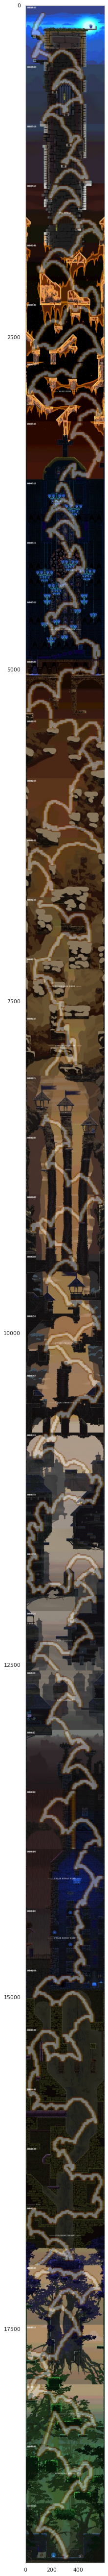

In [39]:
fig, axs = plt.subplots(figsize=(16, 96))

plt.imshow(im)

In [40]:
screen_to_frames[42][0]

(7810, 7950)

In [41]:
cap.set(cv2.CAP_PROP_POS_FRAMES, screen_to_frames[42][0][0])

True

In [42]:
n = 140

In [43]:
for i in range(n):
    ret, frame = cap.read()
    if not (ret):
        print("something went wrong")
        exit(1)

    cv2.imshow('Frame', frame)

    k = cv2.waitKey(100) & 0xFF
    # q to exit
    if k == ord('q'):
        break

cv2.destroyAllWindows()

In [ ]:
cap.release()

what am i going to present:

width 60 of every video

last screen corner case
detect not continuous video corner case

find global position of game on screen
* detect the black line on top
    
* heatmap:
    * array of coordinates
    * for each frame
    * screen = frame_to_screen(i) # offset?
    * background = screen_to_frame[screen]
    * detect king
    * screen_to_positions = {screen: [[x, y]]}
    * after:
    * for each screen
    * make a heatmap
    * https://github.com/TobiasRoeddiger/GazePointHeatMap/blob/master/gazeheatplot.py
    * https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set
    * rgba to make transparent
* statistical
    * screentime
    * number of falls (12-13 screens)
    * number of total falls
* corner cases
    

pipeline:
* map_screens.py and screen_to_frame.py for static files
* map_frames(filename, screen_to_frame)
* for each screen in screen to frames detect motion

https://www.sicara.ai/blog/en/object-detection-template-matching

https://debuggercafe.com/moving-object-detection-using-frame-differencing-with-opencv/

In [44]:
im.shape

(19264, 600, 3)

https://towardsdatascience.com/build-a-motion-heatmap-videousing-opencv-with-python-fd806e8a2340

https://github.com/kjw0612/awesome-deep-vision#imagenet-classification

https://www.pyimagesearch.com/2015/05/25/basic-motion-detection-and-tracking-with-python-and-opencv/